<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Questions-to-Answer" data-toc-modified-id="Questions-to-Answer-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Questions to Answer</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Experimental-Parameters-and-Hyperparameters" data-toc-modified-id="Experimental-Parameters-and-Hyperparameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experimental Parameters and Hyperparameters</a></span></li><li><span><a href="#Synthetic-Training-Data-(no-validation-data-😅)" data-toc-modified-id="Synthetic-Training-Data-(no-validation-data-😅)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Synthetic Training Data (no validation data 😅)</a></span></li><li><span><a href="#Fully-Connected-Neural-Network-With-Linear-Output" data-toc-modified-id="Fully-Connected-Neural-Network-With-Linear-Output-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fully-Connected Neural Network With Linear Output</a></span></li><li><span><a href="#Model-Creation" data-toc-modified-id="Model-Creation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Creation</a></span></li><li><span><a href="#Training-Loop" data-toc-modified-id="Training-Loop-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training Loop</a></span></li><li><span><a href="#Examine-Hidden-Calculations" data-toc-modified-id="Examine-Hidden-Calculations-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Examine Hidden Calculations</a></span></li><li><span><a href="#Examine-Layer-Inputs,-Parameters,-and-Gradients" data-toc-modified-id="Examine-Layer-Inputs,-Parameters,-and-Gradients-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Examine Layer Inputs, Parameters, and Gradients</a></span></li></ul></div>

# Activations, Initialization, and Normalization

This notebook is all about the range of numbers. Specifically, the range of

- input features (pixels, words, distances, stock data, audio waves, etc.),
- activation functions (sigmoid, relu, etc.),
- activations (the outputs of activation functions),
- parameters (weights, biases, etc.), and
- parameter gradients.

Here are a couple of reminders that you might find helpful.

Each neuron implements these two equations:

$$
\begin{align}
Z^{[l]} &= A^{[l-1]} W^{[l]T} + \mathbf{b}^{[l]}\\
A^{[l]} &= g^{[l]}(Z^{[l]})
\end{align}
$$

- $Z^{[l]}$ is the linear output of layer $l$ (e.g., the output of a `nn.Linear` module)
- $A^{[l-1]}$ is a tensor containing all activations for layer $l-1$ (or just a batch of them)
- $W^{[l]}$ is a parameter matrix for layer $l$ called "weights"
- $\mathbf{b}^{[l]}$ is a parameter vector for layer $l$ called "bias"
- $A^{[l]}$ is a tensor containing all activations for layer $l$ (outputs of an activation function, e.g., `nn.Sigmoid`)
- $g^{[l]}(\cdot)$ is the activation function for layer $l$ (e.g., sigmoid)

Here are a couple of activation function examples. Pay close attention to the range of the input values (input values are on the x-axis).

![Sigmoid Activation Function](https://singlepages.github.io/NeuralNetworks/img/Sigmoid.png)

![ReLU Activation Function](https://singlepages.github.io/NeuralNetworks/img/ReLU.png)

## Questions to Answer

These questions will also appear on gradescope.

1. What terms directly impact the output of an activation function?
1. What is the purpose of the bias term in a single neuron?
1. What is the purpose of an activation function (what happens when we remove all activation functions)?
1. Where is the "interesting" / "useful" range for most activation functions?
1. Why are deeper networks generally more useful than shallower networks?
1. What happens to gradients in deeper networks?
1. Why is it an issue for input features to be in the range from 25 to 35?
1. What is a "good" range for input features?
1. Can we "normalize" values between layers?
1. What is the goal when initializing network parameters?

You can use the code below to help find (or confirm) answers to these conceptual questions.

## Imports

In [117]:
import torch
import torch.nn as nn

from torchsummary import summary

from fastprogress.fastprogress import progress_bar

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

## Experimental Parameters and Hyperparameters

I recommend the following process for running quick experiments:

1. Change a value in the cell below.
2. Run the entire notebook (or at least from here down).
3. Examine the output plots.

You can also edit and add any code that you find useful.

In [118]:
# Number of training examples
train_N = 500

# Range of training data input
input_range = (-3, 3)

# Noise factor for training data input
input_noise = 0.1

# Horizontal shift of the training data input (useful for demonstrating input normalization)
input_shift = 0.1

# Noise factor for training data output
output_noise = 0.1

# Vertically shift the sinusoidal output (useful for demonstrating bias)
output_shift = 0.5

# Neural network activation function
#   Options: {nn.ReLU, nn.Sigmoid, None}
activation_module = nn.ReLU

# Neural network output neuron bias (True or False)
output_bias = True

# Neural network architecture (useful for comparing width and depth)
#   neuron : layer_sizes = (1, 1)
#   wider  : layer_sizes = (1, 100, 1)
#   deeper : layer_sizes = (1, 80, 90, 80, 70, 80, 5, 1)
layer_sizes = (1, 8, 1)

# Neural network parameter initialization method
#   Options: {"zeros", "ones", "large", "uniform", "normal", "normal2", "xavier", "kaiming"}
initialization_method = "kaiming"

# Number of training epochs (useful for examining problematic gradients, set to 1)
num_epochs = 2000

## Synthetic Training Data (no validation data 😅)

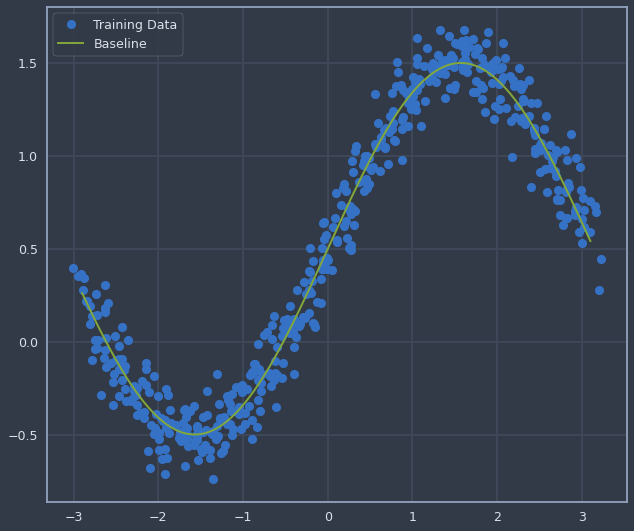

In [119]:
# Baseline signal without noise
X_baseline = torch.linspace(*input_range, train_N).reshape(-1, 1) + input_shift
y_baseline = torch.sin(X_baseline) + output_shift

X = X_baseline + torch.randn(train_N, 1) * input_noise
y = y_baseline + torch.randn(train_N, 1) * output_noise

plt.plot(X, y, "o", label="Training Data")
plt.plot(X_baseline, y_baseline, label="Baseline")

_ = plt.legend()

## Fully-Connected Neural Network With Linear Output

In [120]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes: tuple[int], output_bias: bool, act_mod: nn.Module):
        super(NeuralNetwork, self).__init__()

        def layer(nlm1: int, nl: int) -> nn.Module:
            linear = nn.Linear(nlm1, nl)
            return nn.Sequential(linear, act_mod()) if act_mod else linear

        # Hidden layers
        hidden_layers = [
            layer(nlminus1, nl)
            for nlminus1, nl in zip(layer_sizes[:-2], layer_sizes[1:-1])
        ]

        # Output layer
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1], bias=output_bias)

        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X: torch.tensor):
        return self.layers(X)


def initialize_parameters(layer: nn.Module):
    # Ignore any non-linear layers
    if type(layer) == nn.Linear:
        print("Initializing", layer)

        with torch.no_grad():

            # We can always initialize bias to zero
            if layer.bias is not None:
                layer.bias.fill_(0.0)

            if initialization_method == "zeros":
                layer.weight.fill_(0.0)

            elif initialization_method == "ones":
                layer.weight.fill_(1.0)

            elif initialization_method == "large":
                layer.weight.set_(torch.rand_like(layer.weight) * 10.0)

            elif initialization_method == "uniform":
                layer.weight.uniform_()

            elif initialization_method == "normal":
                layer.weight.normal_()

            elif initialization_method == "normal2":
                fan_out = torch.sqrt(torch.tensor(layer.weight.shape[0]))
                layer.weight.normal_() * (1 / fan_out)

            elif initialization_method == "xavier":
                nn.init.xavier_uniform_(layer.weight)

            elif initialization_method == "kaiming":
                nn.init.kaiming_normal_(layer.weight)

            else:
                print(f"'{initialization_method}' is not handled")


def report_mean_stdev(tensor: torch.tensor, label: str, indent="  "):
    std, mean = torch.std_mean(tensor)
    print(f"{indent}{label} Mean  = {mean.item():.3f}")
    print(f"{indent}{label} Stdev = {std.item():.3f}\n")


def report_layer_info(l: int, layer: nn.Module, A=None):
    print(f"---------------- Layer {l} ---------------")
    print(layer, "\n")
    if A is not None:
        report_mean_stdev(A, "Layer Input")

    if type(layer) == nn.Sequential or type(layer) == nn.Linear:
        W = layer.weight if type(layer) == nn.Linear else layer[0].weight
        b = layer.bias if type(layer) == nn.Linear else layer[0].bias
        report_mean_stdev(W, "Weights")
        if b is not None:
            report_mean_stdev(b, "Bias")
        if W.grad is not None:
            report_mean_stdev(W.grad.abs(), "Weights gradient")
        if b is not None and b.grad is not None:
            report_mean_stdev(b.grad.abs(), "Bias gradient")
    print()

## Model Creation

In [121]:
# Create the model
model = NeuralNetwork(layer_sizes, output_bias, activation_module)
summary(model)

# Use a custom initializer for layer parameters
print()
model.apply(initialize_parameters)

# Report on initial parameter values
print()
for l, layer in enumerate(model.layers):
    report_layer_info(l, layer)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  16
|    |    └─ReLU: 3-2                    --
|    └─Linear: 2-2                       8
Total params: 24
Trainable params: 24
Non-trainable params: 0

Initializing Linear(in_features=1, out_features=8, bias=True)
Initializing Linear(in_features=8, out_features=1, bias=False)

---------------- Layer 0 ---------------
Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): ReLU()
) 

  Weights Mean  = -0.038
  Weights Stdev = 1.148

  Bias Mean  = 0.000
  Bias Stdev = 0.000


---------------- Layer 1 ---------------
Linear(in_features=8, out_features=1, bias=False) 

  Weights Mean  = -0.085
  Weights Stdev = 0.473




## Training Loop

Final loss: 0.025790


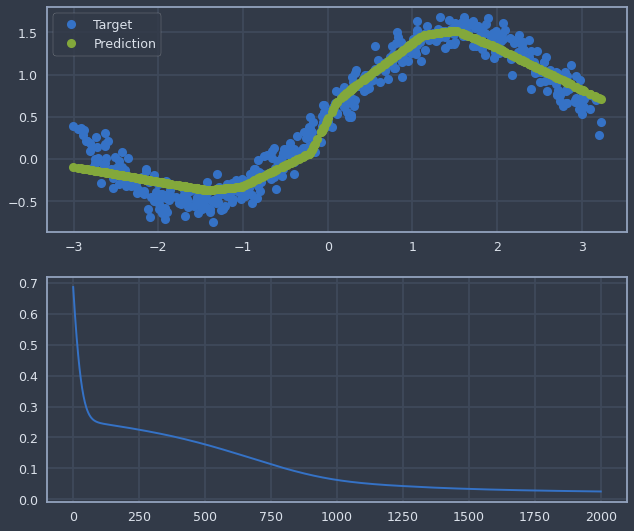

In [122]:
# Train the model and report on the final loss value
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

losses = []

for epoch in progress_bar(range(num_epochs)):
    yhat = model(X)

    loss = criterion(yhat, y)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Final loss: {losses[-1]:.6f}")

yhat = model(X)

_, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(X, y, "o", label="Target")
ax1.plot(X, yhat.detach(), "o", label="Prediction")

ax1.legend()

_ = ax2.plot(losses)

## Examine Hidden Calculations

Let's look at the outputs of the neurons that feed into the output neuron (this will just be in the inputs if you create a single neuron model).

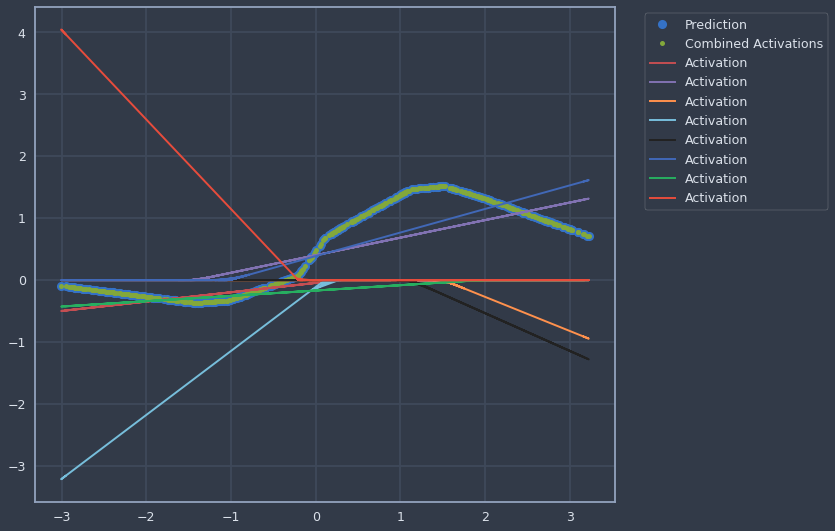

In [123]:
# A "hook" so that we can save the hidden values
def capture_layer_input(module: nn.Module, layer_in, layer_out) -> None:
    global final_layer_input
    final_layer_input = layer_in[0].detach()


# Register hook to capture input to final layer
final_layer_input = None
final_layer = model.layers[-1]
final_layer.register_forward_hook(capture_layer_input)

# Grab parameters for the final layer
WL = final_layer.weight.detach()
bL = final_layer.bias.item() if final_layer.bias is not None else 0.0

# Plot the output of the final layer
yhat = model(X)  # Activate hook
plt.plot(X, yhat.detach(), "o", label="Prediction")

# Compare with hand-computed final layer output
plt.plot(
    X, final_layer_input @ WL.T + bL, "o", markersize=5, label="Combined Activations"
)

# Plot each input to the final layer
plt.plot(X, final_layer_input * WL, label="Activation")

_ = plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Examine Layer Inputs, Parameters, and Gradients

We can get a good idea for inter-layer activations and gradients by printing them off.

In [124]:
with torch.no_grad():
    # Let's call the input to each layer (including the first layer) "A"
    A = X

    # Print the mean and standard deviation for the input (aim for mean 0 and stdev 1)
    report_layer_info(0, "Input Features", A)

    # Do the same for each layer
    for l, layer in enumerate(model.layers):
        A = layer(A)
        report_layer_info(l + 1, layer, A)

---------------- Layer 0 ---------------
Input Features 

  Layer Input Mean  = 0.104
  Layer Input Stdev = 1.735


---------------- Layer 1 ---------------
Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): ReLU()
) 

  Layer Input Mean  = 0.751
  Layer Input Stdev = 1.058

  Weights Mean  = -0.065
  Weights Stdev = 1.078

  Bias Mean  = 0.003
  Bias Stdev = 0.834

  Weights gradient Mean  = 0.002
  Weights gradient Stdev = 0.002

  Bias gradient Mean  = 0.003
  Bias gradient Stdev = 0.002


---------------- Layer 2 ---------------
Linear(in_features=8, out_features=1, bias=False) 

  Layer Input Mean  = 0.506
  Layer Input Stdev = 0.705

  Weights Mean  = -0.114
  Weights Stdev = 0.617

  Weights gradient Mean  = 0.004
  Weights gradient Stdev = 0.003


